In [1]:
from utils.MCGO_Analysis import MCGO_Post_Process
import matplotlib.pyplot as plt
import numpy as np
import f90nml as f90
from scipy.interpolate import interp1d

In [2]:
# Set up case 

mcgo_nc_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/DIIID_FOW_RF_NBIreinj_147634_dt0014_reinj100ms_promptIncluded_ivlim30.nc'
eqdsk_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/g147634.04525'

# create the pp object

mcgo_pp = MCGO_Post_Process(mcgo_nc_file=mcgo_nc_file, eqdsk_file=eqdsk_file, particle_lists_on=True)


['   90   86\n']


Rmin:  1.001
Rmax:  2.377


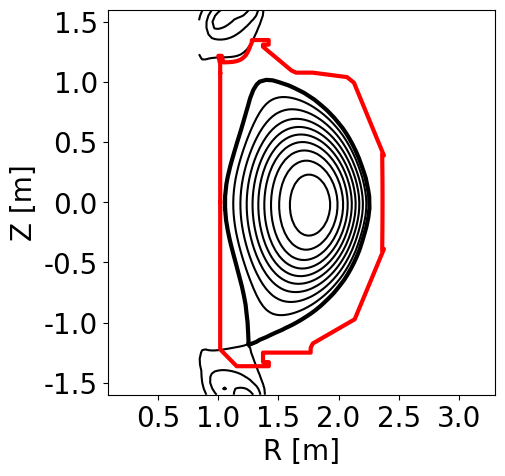

t_bounce 3.630359923550518e-05 [s]


In [3]:
print('Rmin: ', np.min(mcgo_pp.eqdsk['rlim']))
print('Rmax: ', np.max(mcgo_pp.eqdsk['rlim']))
mcgo_pp.plot_equilibrium(figsize=(5,5), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1])

R0 = 1
q = 2
mpart = 3.343e-27
Epart = 5 * 1000 * 1.6022e-19
t_bounce = 4*np.pi*R0*q/np.sqrt(2*Epart/mpart)
print(f't_bounce {t_bounce} [s]')

/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.0 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 5e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 1e+16 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 7e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warn

Text(0.5, 1.0, 'Genray Shot Profiles')

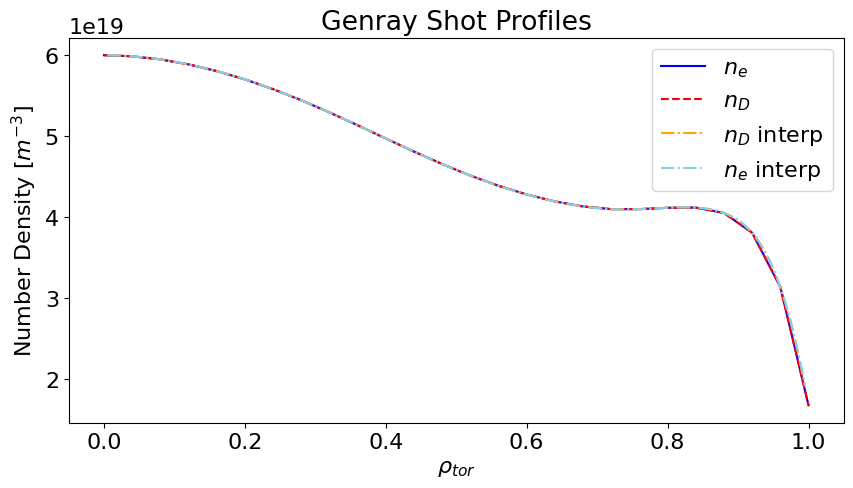

In [4]:
# set up ion and electron temp and density profiles 
rgrid_mcgo = np.linspace(5.0000e-03, 0.995, 100)

# read in genray profiles 
gnr_input_path = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/genray.in'
gnr_nml = f90.read(gnr_input_path)
plt.rcParams.update({'font.size': 16})
dentab = gnr_nml['dentab']['prof']
den = np.array(dentab).reshape(26,3)
den_scale = gnr_nml['plasma']['den_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)

# make ion and electron density interpolator 

ne = den[:,0]*den_scale[0]
nD = den[:,1]*den_scale[1]
#nDfast = den[:,2]*den_scale[2]
fne = interp1d(rgrid, ne, kind='cubic')
fni = interp1d(rgrid, nD, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, ne, label=r'$n_e$', color='blue')
plt.plot(rgrid, nD, label=r'$n_D$', color='red', linestyle='dashed')
plt.plot(rgrid_mcgo, fni(rgrid_mcgo), label=r'$n_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fne(rgrid_mcgo), label=r'$n_e$ interp', color='skyblue', linestyle='-.')
#plt.plot(rgrid, nDfast, label=r'$n_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Number Density [$m^{-3}$]')
plt.title('Genray Shot Profiles')

Text(0.5, 1.0, 'Genray Shot Profiles')

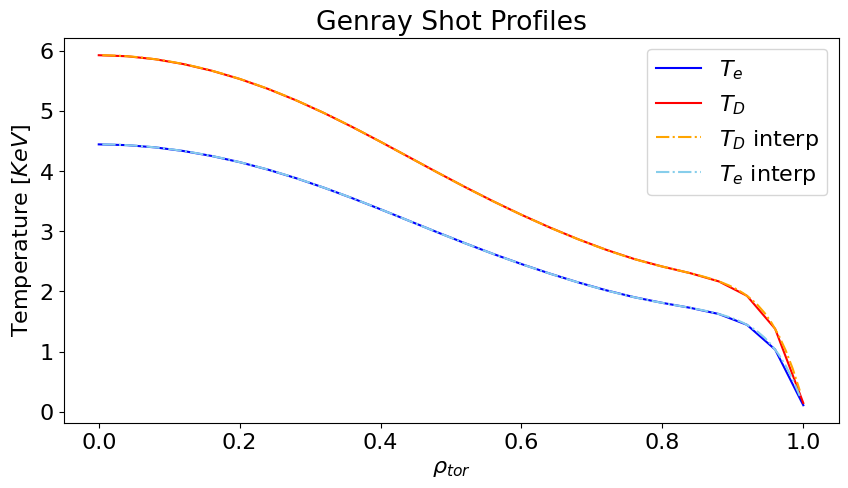

In [5]:
temtab = gnr_nml['temtab']['prof']
tem = np.array(temtab).reshape(26,3)
tem_scale = gnr_nml['plasma']['temp_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)
Te = tem[:,0]*tem_scale[0]
TD = tem[:,1]*tem_scale[1]
TDfast = tem[:,2]*tem_scale[2]
fTe = interp1d(rgrid, Te, kind='cubic')
fTi = interp1d(rgrid, TD, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, Te, label=r'$T_e$', color='blue')
plt.plot(rgrid, TD, label=r'$T_D$', color='red')
plt.plot(rgrid_mcgo, fTi(rgrid_mcgo), label=r'$T_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fTe(rgrid_mcgo), label=r'$T_e$ interp', color='skyblue', linestyle='-.')
#plt.plot(rgrid, TDfast, label=r'$T_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Temperature [$KeV$]')
plt.title('Genray Shot Profiles')

In [6]:
# load up these profiles into the mcgo input file. 

# update densities and temperatures. 
infile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput'
outfile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput_out'

updates = {'rte': rgrid_mcgo.tolist(),
           'te': fTe(rgrid_mcgo).tolist(),
           'rti': rgrid_mcgo.tolist(),
           'ti': fTi(rgrid_mcgo).tolist(),
           'rni(1,1)': rgrid_mcgo.tolist(),
           'eni(1,1)': (fni(rgrid_mcgo)/1e6).tolist()} 

mcgo_pp.update_fortran_input_deck_full(input_file=infile, updates=updates, out_file=outfile)


In [7]:
# Section 2: Post Processing

In [8]:
print(mcgo_pp.rho_grid)
print(mcgo_pp.mcgo_nc.variables['radbnd'][:])
print(mcgo_pp.eqdsk['zmaxis'])

[0.9998444  0.9534384  0.8962468  0.82553977 0.7417026  0.64833724
 0.5519212  0.45801938 0.36548197 0.26943955 0.1652045  0.05028231
 0.07443299 0.20528738 0.3387718  0.47443417 0.61385936 0.7518
 0.87936    0.999867  ]
[1.0556788 1.118934  1.1821891 1.2454443 1.3086994 1.3719546 1.4352098
 1.4984648 1.56172   1.6249751 1.6882303 1.7514855 1.8147405 1.8779957
 1.9412508 2.0045059 2.0677612 2.1310163 2.1942713 2.2575266]
-0.0231968987


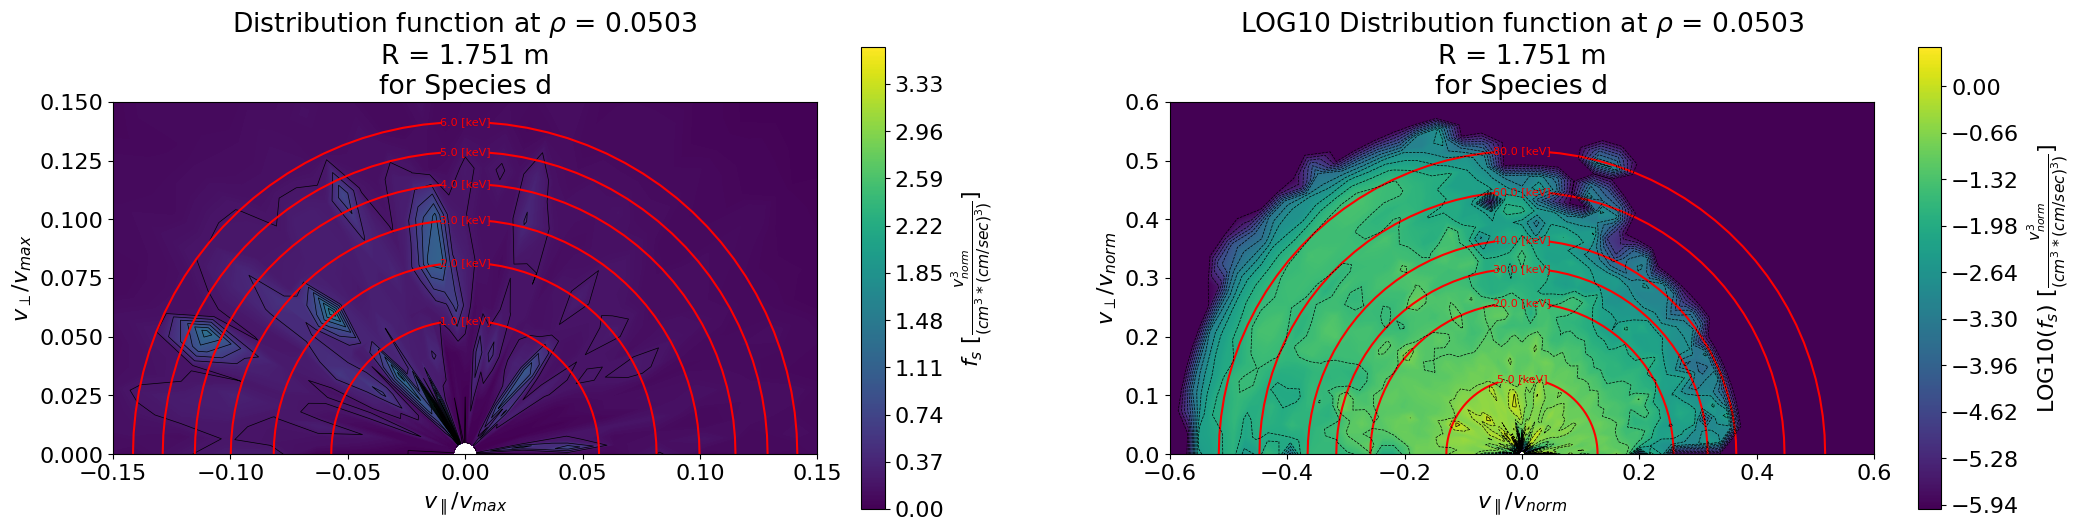

In [9]:
# try out plotting
rho_idx = 11
mcgo_pp.plot_distribution_function_at_rho(
        rho_index=rho_idx,
        v_norm_over_v_max=0.15,
        log_scale_axis_multiple=4,
        log_clip_level=1e-6,
        figsize=(25, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=[1,2,3,4,5,6],
        energy_levels_log=[5, 20, 30, 40, 60, 80],
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

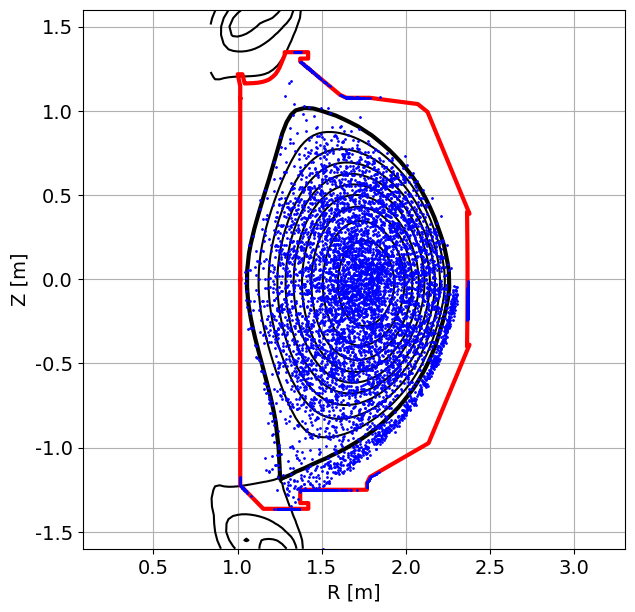

In [10]:
mcgo_pp.plot_particle_end_RZ(figsize=(7,7), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1], fontsize=14, dotsize=2, return_plot=False)

In [11]:
# now, lets try and generate the p2f particle list, run p2f, and then plot the results here! 
filename='/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc'
mcgo_pp.p2f_convert_mcgo_particle_list_to_p2f_particle_list(filename)

File saved to /home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc
 num particles: 7636


In [21]:
# load p2f results 
p2f_out_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/fdis.dav.nc'

mcgo_pp.load_p2f_output(p2f_out_file=p2f_out_file)

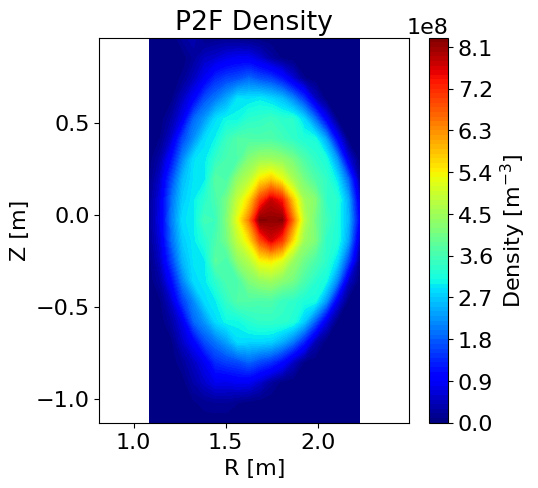

In [22]:
# plot the density
mcgo_pp.p2f_plot_density_RZ(figsize=(8,8))

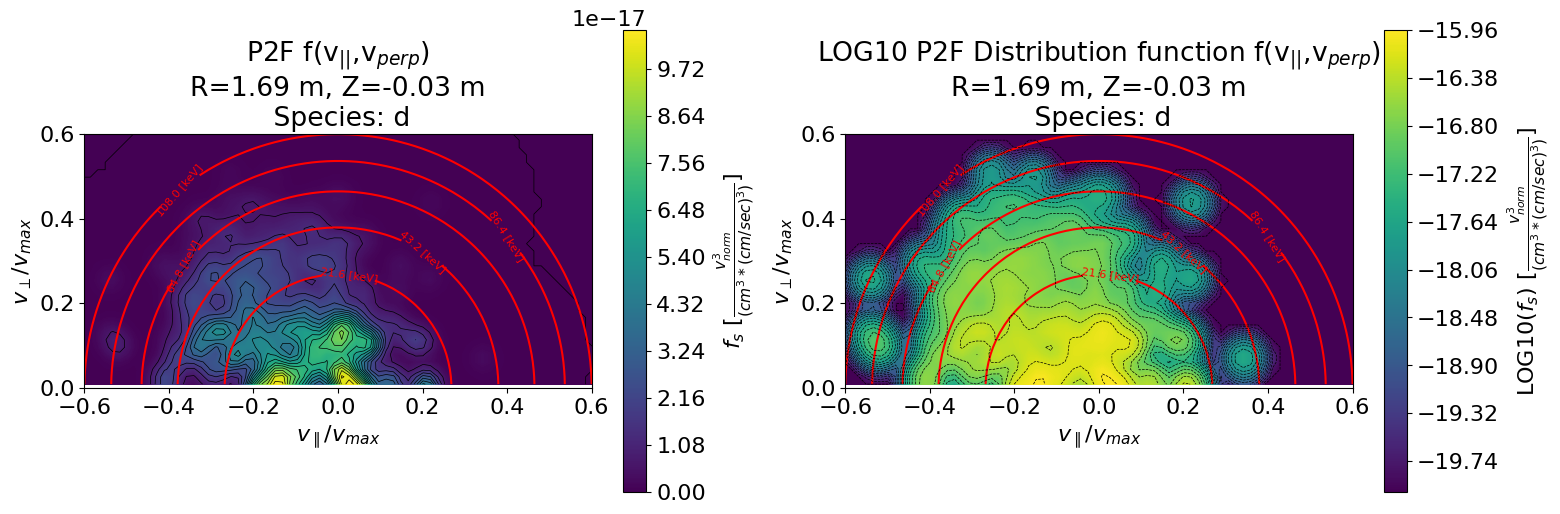

In [26]:
# plot the velocity distribution function 
iR = 10
iZ = 10
mcgo_pp.p2f_plot_distribution_function_at_RZ(
        R_index=iR,
        Z_index=iZ,
        v_norm_over_v_max=0.6,
        log_scale_axis_multiple=1,
        log_clip_level=1e-20,
        figsize=(18, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=None,
        energy_levels_log=None,
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)